# Random Automata Generation

In [89]:
!randaut -n50 -Q2..7 2 -A2 > random_unfiltered.hoa
!randaut -n50 -Q2..7 3 -A2 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 4 -A2 >> random_unfiltered.hoa

!randaut -n50 -Q2..7 2 -A3 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 3 -A3 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 4 -A3 >> random_unfiltered.hoa

!randaut -n50 -Q2..7 2 -A4 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 3 -A4 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 4 -A4 >> random_unfiltered.hoa 

!randaut -n50 -Q2..7 2 -A5 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 3 -A5 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 4 -A5 >> random_unfiltered.hoa 

!randaut -n50 -Q2..7 2 -A6 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 3 -A6 >> random_unfiltered.hoa
!randaut -n50 -Q2..7 4 -A6 >> random_unfiltered.hoa

!autfilt random_unfiltered.hoa -v --is-empty > random_automata.hoa
!rm random_unfiltered.hoa

# Optimization Evaluation

In [76]:
!autcross --timeout=60 -F 'random_automata.hoa' -t\
'{SaG_Base} python3.9 ../SimpleAndGeneral/complement.py %H>%O'\
'{SaG_Skip} python3.9 ../SimpleAndGeneral/complement.py --skip %H>%O'\
'{SaG_Jump} python3.9 ../SimpleAndGeneral/complement.py --jump_levels %H>%O'\
'{SaG_Skip_Jump} python3.9 ../SimpleAndGeneral/complement.py --skip --jump_levels %H>%O'\
'{SaG_Base_AF_Min} python3.9 ../SimpleAndGeneral/complement.py %H | autfilt --small -b >%O'\
'{SaG_Skip_AF_Min} python3.9 ../SimpleAndGeneral/complement.py --skip %H | autfilt --small -b >%O'\
'{SaG_Jump_AF_Min} python3.9 ../SimpleAndGeneral/complement.py --jump_levels %H | autfilt --small -b >%O'\
'{SaG_Skip_Jump_AF_Min} python3.9 ../SimpleAndGeneral/complement.py --skip --jump_levels %H | autfilt --small -b >%O'\
--csv > SaG_Optimization_Results.csv
    

random_automata.hoa:1.1-25.7
Running [A0]: python3.9 ../SimpleAndGeneral/complement.py 'lcr-i0-I90scU'>'lcr-o0-Ut5VnX'
Running [A1]: python3.9 ../SimpleAndGeneral/complement.py --skip 'lcr-i0-0jwDhU'>'lcr-o1-1vgwsY'
Running [A2]: python3.9 ../SimpleAndGeneral/complement.py --jump_levels 'lcr-i0-wy50IX'>'lcr-o2-qP9DRW'
Running [A3]: python3.9 ../SimpleAndGeneral/complement.py --skip --jump_levels 'lcr-i0-xjaZSV'>'lcr-o3-Na6yUW'
Running [A4]: python3.9 ../SimpleAndGeneral/complement.py 'lcr-i0-UgG5iU' | autfilt --small -b >'lcr-o4-zl2z1X'
Running [A5]: python3.9 ../SimpleAndGeneral/complement.py --skip 'lcr-i0-g2FyJU' | autfilt --small -b >'lcr-o5-Q7iamV'
Running [A6]: python3.9 ../SimpleAndGeneral/complement.py --jump_levels 'lcr-i0-EV53kU' | autfilt --small -b >'lcr-o6-V1WuqW'
Running [A7]: python3.9 ../SimpleAndGeneral/complement.py --skip --jump_levels 'lcr-i0-3vg36U' | autfilt --small -b >'lcr-o7-xQtsVW'
Performing sanity checks and gathering statistics...

random_automata.hoa:26.1-

# Data Interpretation I

In [50]:
import pandas as pd

data = pd.read_csv('SaG_Optimization_Results.csv')
tools = ["SaG_Base", "SaG_Skip", "SaG_Jump", "SaG_Skip_Jump",
             "SaG_Base_AF_Min", "SaG_Skip_AF_Min", "SaG_Jump_AF_Min", "SaG_Skip_Jump_AF_Min"]

statenames = ["Base", "Skip", "Jump", "SkipJump",
              "BaseMin", "SkipMin", "JumpMin", "SkipJumpMin"]

input_columns = [col for col in data.columns if col.startswith("input") and col != "input.name"]

results = []

for tool, state_name in zip(tools, statenames):
    tool_results = data[data.tool == tool]
    tool_results = tool_results.rename(columns={"output.states" : state_name})
    results.append(tool_results)
    
data = data[input_columns].drop_duplicates()

for tool_results, state_name in zip(results, statenames):
    data = data.merge(tool_results[["input.source", state_name]], on="input.source", how="inner")


data = data.drop_duplicates()

for state_name in statenames:
    data[state_name] = pd.to_numeric(data[state_name])

tools = ["Base", "Skip", "Jump", "SkipJump", "BaseMin", "SkipMin", "JumpMin", "SkipJumpMin"]

for acc_sets in range(2, 7):
    filtered = data.dropna()
    filtered = filtered[filtered["input.acc_sets"] == acc_sets]

    print(f"Acc_sets = {acc_sets} | ", end="")
    for tool in tools:
        print(f"{tool} : {filtered[tool].sum()} | ", end="")
    print( )
    
print("             | ", end="")
for tool in tools:
    print(f"{tool} : {data.dropna()[tool].sum()} | ", end="")    
    
print()

base_min_smallest_count = (data["BaseMin"] <= data["SkipJumpMin"]).value_counts()[0]
skip_jump_min_smallest_count = (data["SkipJumpMin"] <= data["BaseMin"]).value_counts()[0]

print()
print(f"Using no level jumping Sag produces the smallest or equal to smallest automaton in: {base_min_smallest_count} cases.")
print(f"Using level jumping Sag produces the smallest or equal to smallest automaton in: {skip_jump_min_smallest_count} cases.")

data = data.rename(columns={"input.acc_sets" : "Acceptance Sets"})

data.to_csv("SaG_Optimization_Comparison.csv")



Acc_sets = 2 | Base : 13047 | Skip : 9813 | Jump : 12672 | SkipJump : 9277 | BaseMin : 3862 | SkipMin : 3862 | JumpMin : 3494 | SkipJumpMin : 3494 | 
Acc_sets = 3 | Base : 18527 | Skip : 15129 | Jump : 16634 | SkipJump : 13281 | BaseMin : 5144 | SkipMin : 5144 | JumpMin : 4673 | SkipJumpMin : 4673 | 
Acc_sets = 4 | Base : 29350 | Skip : 25485 | Jump : 25000 | SkipJump : 21330 | BaseMin : 7432 | SkipMin : 7432 | JumpMin : 6338 | SkipJumpMin : 6338 | 
Acc_sets = 5 | Base : 47882 | Skip : 43513 | Jump : 39035 | SkipJump : 34683 | BaseMin : 17563 | SkipMin : 17563 | JumpMin : 14240 | SkipJumpMin : 14240 | 
Acc_sets = 6 | Base : 72472 | Skip : 66290 | Jump : 63659 | SkipJump : 57756 | BaseMin : 41593 | SkipMin : 41593 | JumpMin : 37476 | SkipJumpMin : 37476 | 
             | Base : 181278 | Skip : 160230 | Jump : 157000 | SkipJump : 136327 | BaseMin : 75594 | SkipMin : 75594 | JumpMin : 66221 | SkipJumpMin : 66221 | 

Using no level jumping Sag produces the smallest or equal to smallest aut

# Tool comparison

In [84]:
!autcross --timeout=60 -F 'random_automata.hoa' -t\
'{SaG+}python3.9 ../SimpleAndGeneral/complement.py --skip --jump_levels %H | autfilt --small -b >%O'\
'{Autfilt+}autfilt --complement --small -b'\
'{Seminator+}tools/seminator/seminator --complement %H | autfilt --small -b >%O'\
'{Kofola+}tools/kofola/kofola --algo=comp %H| autfilt --small -b >%O'\
--csv > Tool_Comparison_Results.csv


random_automata.hoa:1.1-25.7
Running [A0]: python3.9 ../SimpleAndGeneral/complement.py --skip --jump_levels 'lcr-i0-6rCdJh' | autfilt --small -b >'lcr-o0-H3ltzi'
Running [A1]: autfilt --complement --small -b 'lcr-i0-5kqlXg'>'lcr-o1-hbBTWf'
Running [A2]: tools/seminator/seminator --complement 'lcr-i0-wtryFi' | autfilt --small -b >'lcr-o2-8qGSVg'
Running [A3]: tools/kofola/kofola --algo=comp 'lcr-i0-PougKi'| autfilt --small -b >'lcr-o3-9vlzCg'
Performing sanity checks and gathering statistics...

random_automata.hoa:26.1-41.7
Running [A0]: python3.9 ../SimpleAndGeneral/complement.py --skip --jump_levels 'lcr-i1-TKITzi' | autfilt --small -b >'lcr-o0-tsc8Tf'
Running [A1]: autfilt --complement --small -b 'lcr-i1-31vwNh'>'lcr-o1-QlRFQj'
Running [A2]: tools/seminator/seminator --complement 'lcr-i1-Hv2cik' | autfilt --small -b >'lcr-o2-ZBcVTi'
Running [A3]: tools/kofola/kofola --algo=comp 'lcr-i1-Fa0xrg'| autfilt --small -b >'lcr-o3-TDVJ0g'
Performing sanity checks and gathering statistics...


# Data Interpretation II

In [85]:
data = pd.read_csv('Tool_Comparison_Results.csv')

tools = ["SaG+", "Autfilt+", "Seminator+", "Kofola+",]

input_columns = [col for col in data.columns if col.startswith("input") and col != "input.name"]

results = []

for tool in tools:
    tool_results = data[data.tool == tool]
    tool_results = tool_results.rename(columns={"output.states" : tool})
    results.append(tool_results)
    
data = data[input_columns].drop_duplicates().rename(columns={"input.acc_sets" : "Acceptance Sets"})

for tool_results, tool in zip(results, tools):
    data = data.merge(tool_results[["input.source", tool]], on="input.source", how="inner")

data = data.drop_duplicates()

for tool in tools:
    data[tool] = pd.to_numeric(data[tool])

for acc_sets in range(2, 7):
    filtered = data.dropna()
    filtered = filtered[filtered["Acceptance Sets"] == acc_sets]

    print(f"Acc_sets = {acc_sets} | ", end="")
    
    for tool in tools:
        print(f"{tool} : sum = {filtered[tool].sum()}; mean = {filtered[tool].mean():.2f}; std = {filtered[tool].std():.2f} | ", end="")

    print()
    
print("             | ", end="")
for tool in tools:
    tmp = data.dropna()
    print(f"{tool} : sum = {tmp[tool].sum()}; mean = {tmp[tool].mean():.2f}; std = {tmp[tool].std():.2f} | ", end="")
print("\n")

for tool in tools[1:]:
    comparison = ((data["SaG+"] <= data[tool]) | data[tool].isna()).value_counts()[1]
    print(f"Against {tool}, SaG produces smaller or equal automaton in {comparison} cases.")

print()

for tool in tools[1:]:
    comparison = ((data["SaG+"] < data[tool]) | data[tool].isna()).value_counts()[1]
    print(f"Against {tool}, SaG produces smaller automaton in {comparison} cases.")  

print()

SaG_smallest = (((data["SaG+"] <= data["Autfilt+"]) | data["Autfilt+"].isna()) &\
                ((data["SaG+"] <= data["Seminator+"]) | data["Seminator+"].isna()) &\
                ((data["SaG+"] <= data["Kofola+"]) | data["Kofola+"].isna())).value_counts()[1]

print(f"SaG produces the smallest or equal to smallest automaton in {SaG_smallest} cases.")

SaG_strictly_smallest = (((data["SaG+"] < data["Autfilt+"]) | data["Autfilt+"].isna()) &\
                         ((data["SaG+"] < data["Seminator+"]) | data["Seminator+"].isna()) &\
                         ((data["SaG+"] < data["Kofola+"]) | data["Kofola+"].isna())).value_counts()[1]

print(f"SaG produces the smallest automaton in {SaG_strictly_smallest} cases.")


Acc_sets = 2 | SaG+ : sum = 3494.0; mean = 39.70; std = 44.88 | Autfilt+ : sum = 1933.0; mean = 21.97; std = 25.40 | Seminator+ : sum = 2202.0; mean = 25.02; std = 27.04 | Kofola+ : sum = 1917.0; mean = 21.78; std = 22.54 | 
Acc_sets = 3 | SaG+ : sum = 3735.0; mean = 52.61; std = 43.46 | Autfilt+ : sum = 2161.0; mean = 30.44; std = 28.62 | Seminator+ : sum = 2243.0; mean = 31.59; std = 25.20 | Kofola+ : sum = 2157.0; mean = 30.38; std = 24.98 | 
Acc_sets = 4 | SaG+ : sum = 5877.0; mean = 94.79; std = 139.00 | Autfilt+ : sum = 6162.0; mean = 99.39; std = 327.38 | Seminator+ : sum = 35819.0; mean = 577.73; std = 3978.86 | Kofola+ : sum = 6131.0; mean = 98.89; std = 310.09 | 
Acc_sets = 5 | SaG+ : sum = 5724.0; mean = 108.00; std = 138.10 | Autfilt+ : sum = 73208.0; mean = 1381.28; std = 9150.45 | Seminator+ : sum = 20860.0; mean = 393.58; std = 2304.52 | Kofola+ : sum = 68077.0; mean = 1284.47; std = 8690.79 | 
Acc_sets = 6 | SaG+ : sum = 16647.0; mean = 339.73; std = 1142.98 | Autfilt+ 

# Plot Generation

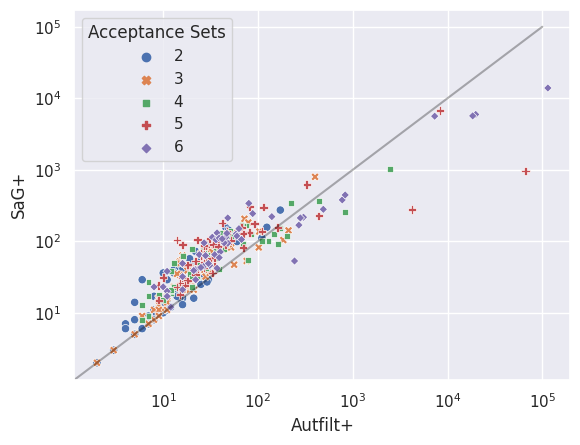

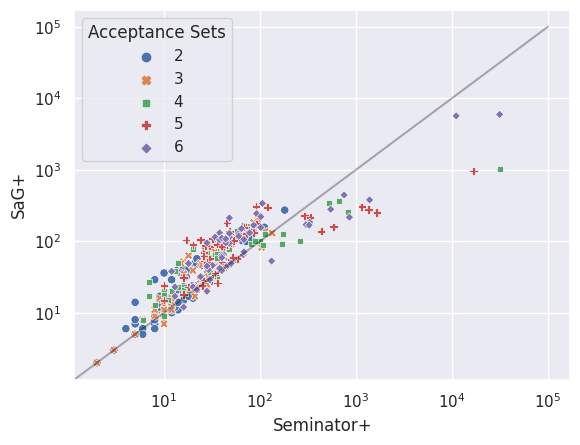

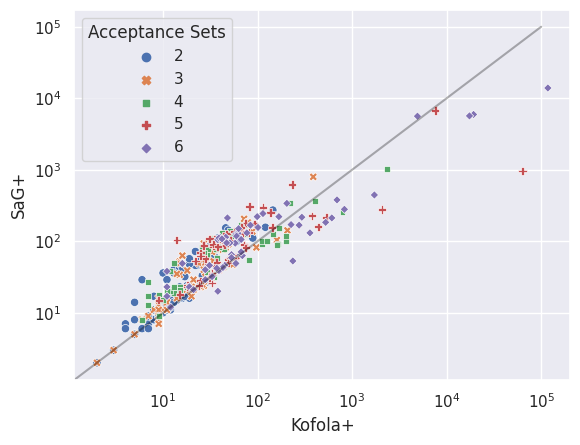

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

tools = ["Autfilt+", "Seminator+", "Kofola+"]

for tool in tools:
    plt.xscale('log')
    plt.yscale('log')
    plt.plot([0,10**5],[0,10**5], color="black", alpha=0.3)

    plot = sns.scatterplot(data=data, x=tool, y="SaG+", style="Acceptance Sets", hue="Acceptance Sets", palette="deep")
    fig = plot.get_figure()

    fig.savefig(f"SaG-{tool}.svg", dpi=300)
    plt.show()
